In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import precision_score, recall_score, roc_auc_score
%matplotlib inline

In [31]:
df = pd.read_csv("./data.csv")
df = df[[
    'Make',
    'Model',
    'Year',
    'Engine HP',
    'Engine Cylinders',
    'Transmission Type',
    'Vehicle Style',
    'highway MPG',
    'city mpg',
    'MSRP'

]]
df.columns = df.columns.str.replace(' ', '_').str.lower()

df.fillna(0, inplace=True)

In [32]:
msrp = df.msrp
above_average = (msrp > msrp.mean()).astype(int)
df.drop('msrp', axis=1, inplace=True)

In [80]:
df_full_train, df_test, y_full_train, y_test = train_test_split(df, above_average, test_size=0.2, random_state=1)
df_train, df_val, y_train, y_val = train_test_split(df_rest, y_rest, test_size=0.25, random_state=1)

numerical = df.columns[df.dtypes != 'object'].values

In [81]:
# Question 1
for n in numerical:
  score = roc_auc_score(y_train, df_train[n])
  neg_score = roc_auc_score(y_train, -df_train[n])
  print(f'{n:17s} -> {score if score > 0.5 else neg_score}')

year              -> 0.7076614891518739
engine_hp         -> 0.9058701614891518
engine_cylinders  -> 0.75143537352071
highway_mpg       -> 0.6135955991124259
city_mpg          -> 0.6511379746055226


In [82]:
# Question 2
dv = DictVectorizer(sparse=False)

X_train = dv.fit_transform(df_train.to_dict(orient='records'))
X_val = dv.transform(df_val.to_dict(orient='records'))

lr_model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
lr_model.fit(X_train, y_train)

y_pred = lr_model.predict_proba(X_val)[:, 1]
score = roc_auc_score(y_val, y_pred)
round(score, 3)

0.986

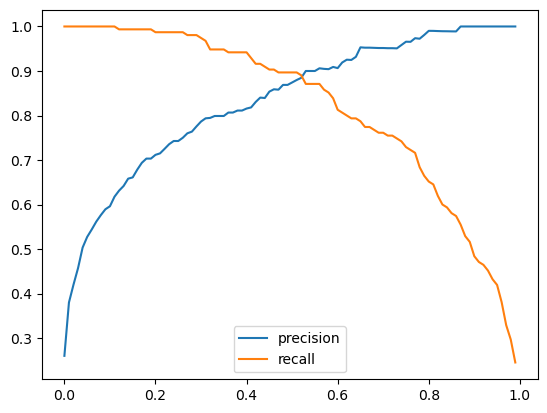

In [83]:
# Question 3
p, r = [], []
thresholds = np.arange(0, 1, 0.01)
for t in thresholds:
  score = y_pred >= t
  p_ = precision_score(y_val, score)
  r_ = recall_score(y_val, score)
  p.append(p_)
  r.append(r_)

plt.plot(thresholds, p, label='precision')
plt.plot(thresholds, r, label='recall')
plt.legend()
plt.show()

In [84]:
# Question 4
f1 = []
for i in range(len(p)):
  score = 2 * p[i] * r[i] / (p[i] + r[i])
  f1.append(score)
thresholds[np.argmax(f1)]

0.51

In [93]:
# Question 5
kf = KFold(n_splits=5, shuffle=True, random_state=1)
scores = []
for train_idx, val_idx in kf.split(df_full_train):
  df_train = df_full_train.iloc[train_idx]
  df_val = df_full_train.iloc[val_idx]

  y_train = y_full_train.iloc[train_idx]
  y_val = y_full_train.iloc[val_idx]
  
  dv = DictVectorizer(sparse=False)
  X_train = dv.fit_transform(df_train.to_dict(orient='records'))
  X_val = dv.transform(df_val.to_dict(orient='records'))

  lr_model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
  lr_model.fit(X_train, y_train)

  y_pred = lr_model.predict_proba(X_val)[:, 1]
  score = roc_auc_score(y_val, y_pred)
  scores.append(score)

In [94]:
np.std(scores)

0.0013708864135055317

In [95]:
# Question 6
res = []
for C in [0.01, 0.1, 0.5, 10]:
  kf = KFold(n_splits=5, shuffle=True, random_state=1)
  scores = []
  for train_idx, val_idx in kf.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = y_full_train.iloc[train_idx]
    y_val = y_full_train.iloc[val_idx]
    
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(df_train.to_dict(orient='records'))
    X_val = dv.transform(df_val.to_dict(orient='records'))

    lr_model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    lr_model.fit(X_train, y_train)

    y_pred = lr_model.predict_proba(X_val)[:, 1]
    score = roc_auc_score(y_val, y_pred)
    scores.append(score)
  print(f'{C:.3f} | {np.mean(scores):.9f} | {np.std(scores):.9f}')


0.010 | 0.951585805 | 0.002488170
0.100 | 0.971575298 | 0.001323366
0.500 | 0.977845504 | 0.002932158
10.000 | 0.980862651 | 0.002439994
